In [1]:
%config Completer.use_jedi = False

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, precision_score
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split

In [3]:
df = pd.read_csv('TechStockDataForModelNoOutliers.csv')

train, test = train_test_split(df, test_size=0.1, random_state=42)

X_train, y_train = train.drop(['SP_change_Target', 'Target'], axis=1), train['Target']
X_test, y_test = test.drop(['SP_change_Target', 'Target'], axis=1), test['Target']

In [4]:
X_train.head()

,RSI_10,HighCloseVolAvg_1,HighCloseVolAvg_5,HighCloseVolAvg_20,SP_change_1,SP_change_3,SP_change_5,SP_change_10
42448,42.409992,0.013065,0.011625,0.013884,-0.004523,0.019598,0.025628,-0.037688
42029,69.719460,0.002874,0.027113,0.024579,0.023467,0.045977,0.090517,0.169061
31599,69.204996,0.023893,0.019681,0.023036,0.039111,0.049003,0.086973,0.070309
19557,51.365222,0.004933,0.014092,0.012958,0.012580,0.033054,0.016280,-0.018747
45195,70.692268,0.025818,0.024667,0.021748,0.000901,0.027920,0.015611,0.065746


In [5]:
### Helper functions

def model_fit_and_scores(grid, X, y):
    """
    Fit a model to X and y using a gridsearchCV with param grid.
    Return the model, model's best params, 5 best scores.
    """
    grid.fit(X,y)
    best_params = grid.best_params_
    best_scores = np.sort(grid.cv_results_['mean_test_score'])[::-1][:5]

    return grid, best_params, best_scores


def model_evaluation(model, X_test, y_test):
    """
    Evaluate a model by getting predictions, probabilities,
    print confusion matrix and classification report, then bar plot the results.
    """
    preds = model.predict(X_test)
    
    plot_confusion_matrix(model, X_test, y_test)
        
    print(classification_report(y_test, preds))


def compare_prediction(model, X_test, y_test, test):
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]
    
    data = np.column_stack((test['SP_change_Target'], y_test, preds, probs))

    test_preds_df = pd.DataFrame(data=data, columns=['SP_change_Target', 'Target', 'Predicted', 'Probability'])
    
    prob_thresh = np.linspace(0.4, 0.8, 25)
    
    sp_changes = df['SP_change_Target'].iloc[y_test.index]

    data = []
    for prob in prob_thresh:
        ser = test_preds_df[test_preds_df['Probability']>=prob]['SP_change_Target']
        
        avg = ser.mean()
        count = ser.shape[0]
        
        data.append([avg, count])
        
    prob_sp_df = pd.DataFrame(data=data, index=prob_thresh, columns=['SP_increase', 'Count'])
    
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 15))
    
    sns.barplot(data=test_preds_df, x='Predicted', y='SP_change_Target', ax=ax[1])
    
    ax[0].plot(prob_sp_df.index, prob_sp_df['SP_increase'])
    
    print(prob_sp_df)

### Logistic Model

In [6]:
preprocessing = ColumnTransformer([
    ('scaler', StandardScaler(), X_train.select_dtypes(include='number').columns),
])

custom_scorer = make_scorer(precision_score, greater_is_better=True, pos_label='Yes')


log_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('log', LogisticRegression(max_iter=10000)),
])

log_param_grid = {'log__penalty': ['l2'],
                  'log__C': [0.005],
                  'log__solver': ['lbfgs']
                 }

custom_scorer = make_scorer(precision_score, 
                            greater_is_better=True, 
                            pos_label='Yes')

log_grid = GridSearchCV(estimator=log_pipeline, 
                        param_grid=log_param_grid, 
                        cv=5, 
                        scoring=custom_scorer, 
                        verbose=2)

In [7]:
log_model, log_params, log_best_scores = model_fit_and_scores(log_grid, X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ...log__C=0.005, log__penalty=l2, log__solver=lbfgs; total time=   0.0s
[CV] END ...log__C=0.005, log__penalty=l2, log__solver=lbfgs; total time=   0.1s
[CV] END ...log__C=0.005, log__penalty=l2, log__solver=lbfgs; total time=   0.0s
[CV] END ...log__C=0.005, log__penalty=l2, log__solver=lbfgs; total time=   0.0s
[CV] END ...log__C=0.005, log__penalty=l2, log__solver=lbfgs; total time=   0.0s


In [8]:
log_params

{'log__C': 0.005, 'log__penalty': 'l2', 'log__solver': 'lbfgs'}

In [9]:
log_best_scores

array([0.58141334])

          SP_increase  Count
0.400000     0.032104  40329
0.416667     0.033243  37006
0.433333     0.034414  33311
0.450000     0.035679  29303
0.466667     0.037144  25373
0.483333     0.038649  21428
0.500000     0.040379  17889
0.516667     0.041474  14863
0.533333     0.043249  12266
0.550000     0.044488   9972
0.566667     0.046077   8027
0.583333     0.047832   6455
0.600000     0.049099   5116
0.616667     0.051092   4023
0.633333     0.052547   3082
0.650000     0.053770   2312
0.666667     0.054707   1759
0.683333     0.057413   1286
0.700000     0.056740    951
0.716667     0.058518    639
0.733333     0.057645    395
0.750000     0.060966    249
0.766667     0.065714    143
0.783333     0.063344     69
0.800000     0.074614     35


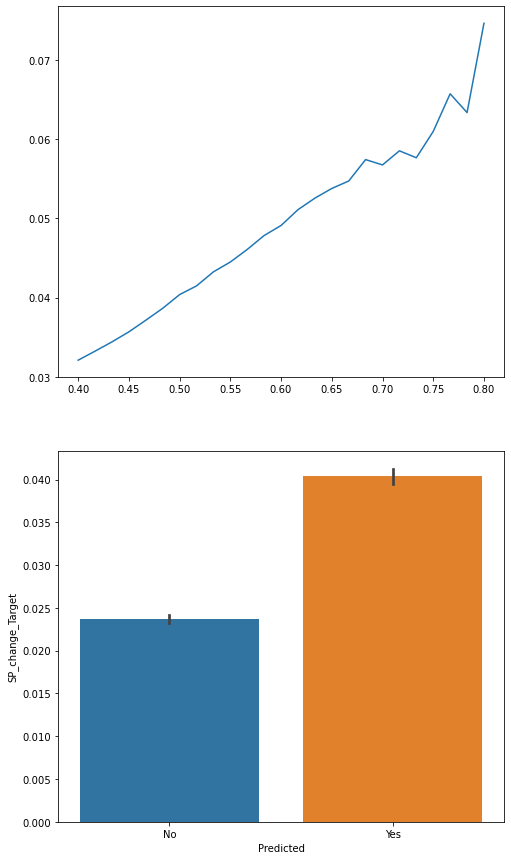

In [10]:
compare_prediction(log_model, X_train, y_train, train)

              precision    recall  f1-score   support

          No       0.57      0.68      0.62     23527
         Yes       0.58      0.46      0.52     22562

    accuracy                           0.57     46089
   macro avg       0.58      0.57      0.57     46089
weighted avg       0.58      0.57      0.57     46089



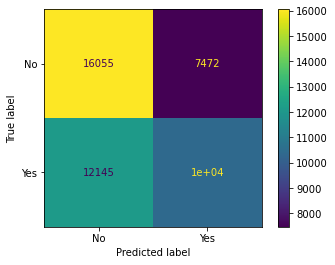

In [11]:
model_evaluation(log_model, X_train, y_train)

### Random Forest Model

In [12]:
custom_scorer = make_scorer(precision_score, greater_is_better=True, pos_label='Yes')


rf_pipeline = Pipeline([
    ('rf', RandomForestClassifier(random_state=42)),
])

rf_param_grid = {'rf__max_depth': [2, 4, 6],
                  'rf__n_estimators': [25, 100, 250],
                 }

custom_scorer = make_scorer(precision_score, 
                            greater_is_better=True, 
                            pos_label='Yes')

rf_grid = GridSearchCV(estimator=rf_pipeline, 
                        param_grid=rf_param_grid, 
                        cv=5, 
                        scoring=custom_scorer, 
                        verbose=2,
                        return_train_score=True)

rf_model, rf_params, rf_best_scores = model_fit_and_scores(rf_grid, X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ...............rf__max_depth=2, rf__n_estimators=25; total time=   0.3s
[CV] END ...............rf__max_depth=2, rf__n_estimators=25; total time=   0.3s
[CV] END ...............rf__max_depth=2, rf__n_estimators=25; total time=   0.3s
[CV] END ...............rf__max_depth=2, rf__n_estimators=25; total time=   0.3s
[CV] END ...............rf__max_depth=2, rf__n_estimators=25; total time=   0.3s
[CV] END ..............rf__max_depth=2, rf__n_estimators=100; total time=   1.3s
[CV] END ..............rf__max_depth=2, rf__n_estimators=100; total time=   1.3s
[CV] END ..............rf__max_depth=2, rf__n_estimators=100; total time=   1.3s
[CV] END ..............rf__max_depth=2, rf__n_estimators=100; total time=   1.3s
[CV] END ..............rf__max_depth=2, rf__n_estimators=100; total time=   1.3s
[CV] END ..............rf__max_depth=2, rf__n_estimators=250; total time=   3.3s
[CV] END ..............rf__max_depth=2, rf__n_est

In [13]:
rf_params

{'rf__max_depth': 6, 'rf__n_estimators': 250}

In [14]:
rf_best_scores

array([0.56917603, 0.56879539, 0.56857208, 0.56756122, 0.56668725])

          SP_increase  Count
0.400000     0.033533  37501
0.416667     0.034228  35793
0.433333     0.035050  33789
0.450000     0.035798  31689
0.466667     0.036684  29483
0.483333     0.037497  27286
0.500000     0.038825  24429
0.516667     0.040558  20997
0.533333     0.042503  17561
0.550000     0.045048  13377
0.566667     0.047646   9756
0.583333     0.050768   6845
0.600000     0.053896   4446
0.616667     0.057410   2684
0.633333     0.060588   1505
0.650000     0.067493    697
0.666667     0.067853    208
0.683333     0.076205     76
0.700000     0.070885     25
0.716667     0.087247      5
0.733333          NaN      0
0.750000          NaN      0
0.766667          NaN      0
0.783333          NaN      0
0.800000          NaN      0


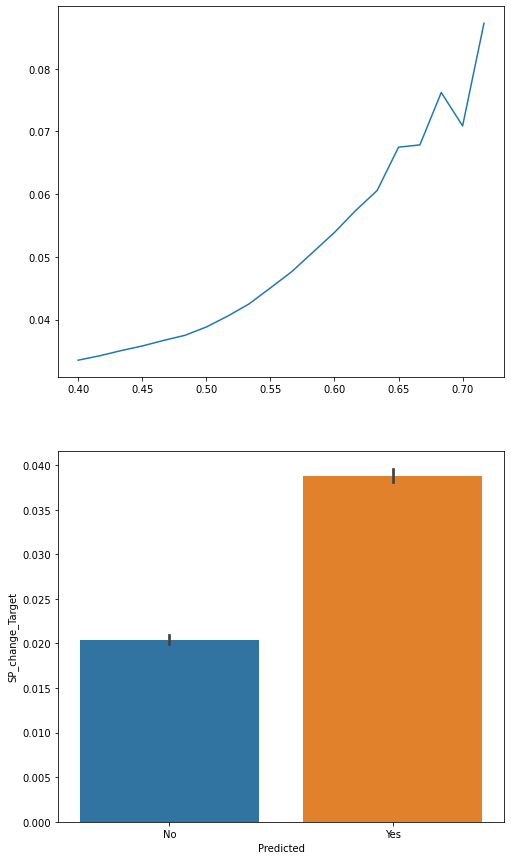

In [15]:
compare_prediction(rf_model, X_train, y_train, train)

### KNN

In [16]:
preprocessing = ColumnTransformer([
    ('scaler', StandardScaler(), X_train.select_dtypes(include='number').columns),
])

custom_scorer = make_scorer(precision_score, greater_is_better=True, pos_label='Yes')


knn_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('knn', KNeighborsClassifier()),
])

knn_param_grid = {'knn__n_neighbors': list(range(5, 30)),
                 }

custom_scorer = make_scorer(precision_score, 
                            greater_is_better=True, 
                            pos_label='Yes')

knn_grid = GridSearchCV(estimator=knn_pipeline, 
                        param_grid=knn_param_grid, 
                        cv=5, 
                        scoring=custom_scorer, 
                        verbose=2)
knn_model, knn_params, knn_best_scores = model_fit_and_scores(knn_grid, X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END .................................knn__n_neighbors=5; total time=   0.8s
[CV] END .................................knn__n_neighbors=5; total time=   0.8s
[CV] END .................................knn__n_neighbors=5; total time=   0.8s
[CV] END .................................knn__n_neighbors=5; total time=   0.8s
[CV] END .................................knn__n_neighbors=5; total time=   0.8s
[CV] END .................................knn__n_neighbors=6; total time=   0.9s
[CV] END .................................knn__n_neighbors=6; total time=   0.9s
[CV] END .................................knn__n_neighbors=6; total time=   0.9s
[CV] END .................................knn__n_neighbors=6; total time=   0.9s
[CV] END .................................knn__n_neighbors=6; total time=   0.9s
[CV] END .................................knn__n_neighbors=7; total time=   0.9s
[CV] END .................................knn__

[CV] END ................................knn__n_neighbors=25; total time=   1.3s
[CV] END ................................knn__n_neighbors=25; total time=   1.3s
[CV] END ................................knn__n_neighbors=25; total time=   1.2s
[CV] END ................................knn__n_neighbors=25; total time=   1.2s
[CV] END ................................knn__n_neighbors=26; total time=   1.3s
[CV] END ................................knn__n_neighbors=26; total time=   1.4s
[CV] END ................................knn__n_neighbors=26; total time=   1.3s
[CV] END ................................knn__n_neighbors=26; total time=   1.2s
[CV] END ................................knn__n_neighbors=26; total time=   1.2s
[CV] END ................................knn__n_neighbors=27; total time=   1.3s
[CV] END ................................knn__n_neighbors=27; total time=   1.3s
[CV] END ................................knn__n_neighbors=27; total time=   1.2s
[CV] END ...................

In [17]:
knn_params

{'knn__n_neighbors': 18}

In [18]:
knn_best_scores

array([0.57740199, 0.5763879 , 0.57602799, 0.57593981, 0.57592677])

          SP_increase  Count
0.400000     0.037227  30659
0.416667     0.037227  30659
0.433333     0.037227  30659
0.450000     0.040289  24898
0.466667     0.040289  24898
0.483333     0.040289  24898
0.500000     0.040289  24898
0.516667     0.043804  18903
0.533333     0.043804  18903
0.550000     0.043804  18903
0.566667     0.047956  13194
0.583333     0.047956  13194
0.600000     0.047956  13194
0.616667     0.052396   8362
0.633333     0.052396   8362
0.650000     0.052396   8362
0.666667     0.057330   4676
0.683333     0.057330   4676
0.700000     0.057330   4676
0.716667     0.057330   4676
0.733333     0.064217   2237
0.750000     0.064217   2237
0.766667     0.064217   2237
0.783333     0.071097    919
0.800000     0.071097    919


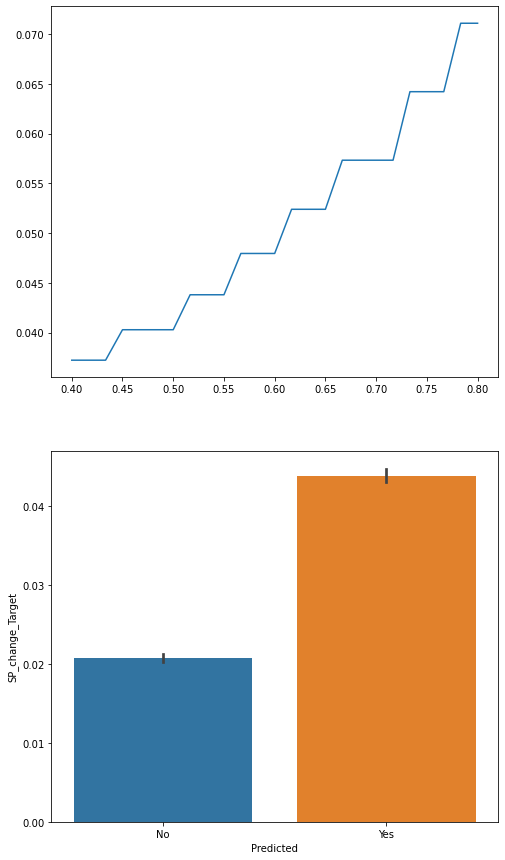

In [19]:
compare_prediction(knn_model, X_train, y_train, train)

### Evaluate on Test Set

          SP_increase  Count
0.400000     0.032550   4449
0.416667     0.033831   4058
0.433333     0.034906   3680
0.450000     0.036686   3232
0.466667     0.038001   2779
0.483333     0.039891   2360
0.500000     0.042062   1975
0.516667     0.044367   1632
0.533333     0.045144   1349
0.550000     0.047344   1096
0.566667     0.050454    889
0.583333     0.052869    707
0.600000     0.055010    556
0.616667     0.058372    431
0.633333     0.057122    333
0.650000     0.060837    245
0.666667     0.062849    192
0.683333     0.069875    141
0.700000     0.073631     95
0.716667     0.069838     64
0.733333     0.074141     43
0.750000     0.087053     24
0.766667     0.088775     11
0.783333     0.048504      6
0.800000     0.030645      4


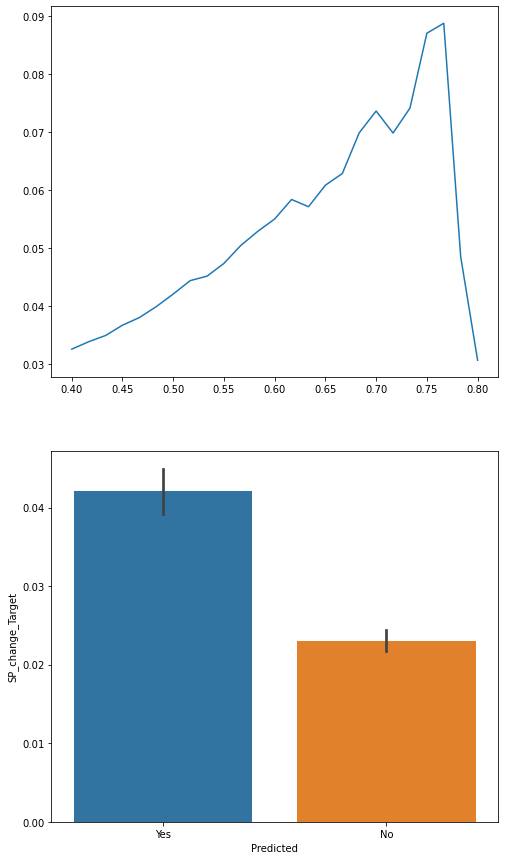

In [20]:
compare_prediction(log_model, X_test, y_test, test)

          SP_increase  Count
0.400000     0.033809   4132
0.416667     0.034629   3935
0.433333     0.035486   3711
0.450000     0.036350   3481
0.466667     0.037206   3238
0.483333     0.037945   3001
0.500000     0.039586   2694
0.516667     0.041171   2299
0.533333     0.042837   1910
0.550000     0.046513   1437
0.566667     0.050418   1038
0.583333     0.050663    714
0.600000     0.051400    470
0.616667     0.056029    277
0.633333     0.056610    152
0.650000     0.063930     65
0.666667     0.058227     16
0.683333     0.076991      5
0.700000     0.109160      3
0.716667          NaN      0
0.733333          NaN      0
0.750000          NaN      0
0.766667          NaN      0
0.783333          NaN      0
0.800000          NaN      0


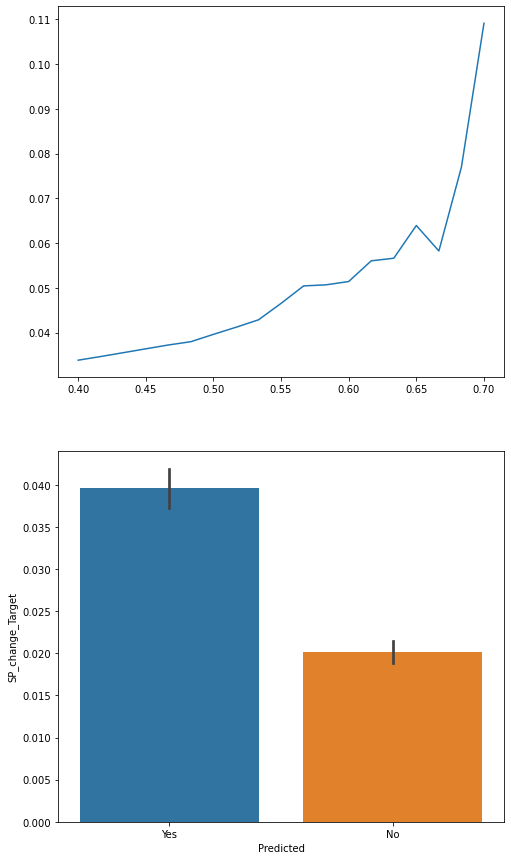

In [21]:
compare_prediction(rf_model, X_test, y_test, test)

          SP_increase  Count
0.400000     0.035784   3382
0.416667     0.035784   3382
0.433333     0.035784   3382
0.450000     0.037706   2752
0.466667     0.037706   2752
0.483333     0.037706   2752
0.500000     0.037706   2752
0.516667     0.039496   2059
0.533333     0.039496   2059
0.550000     0.039496   2059
0.566667     0.043070   1420
0.583333     0.043070   1420
0.600000     0.043070   1420
0.616667     0.045887    878
0.633333     0.045887    878
0.650000     0.045887    878
0.666667     0.050020    500
0.683333     0.050020    500
0.700000     0.050020    500
0.716667     0.050020    500
0.733333     0.053963    265
0.750000     0.053963    265
0.766667     0.053963    265
0.783333     0.056030    115
0.800000     0.056030    115


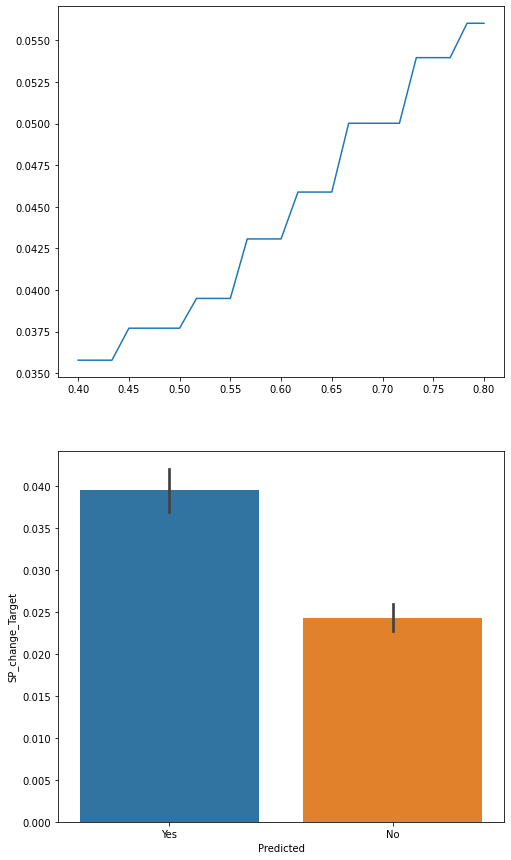

In [22]:
compare_prediction(knn_model, X_test, y_test, test)

              precision    recall  f1-score   support

          No       0.58      0.68      0.63      2665
         Yes       0.57      0.46      0.51      2457

    accuracy                           0.58      5122
   macro avg       0.58      0.57      0.57      5122
weighted avg       0.58      0.58      0.57      5122



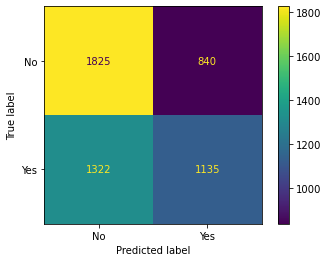

In [23]:
model_evaluation(log_model, X_test, y_test)

              precision    recall  f1-score   support

          No       0.61      0.56      0.59      2665
         Yes       0.56      0.62      0.59      2457

    accuracy                           0.59      5122
   macro avg       0.59      0.59      0.59      5122
weighted avg       0.59      0.59      0.59      5122



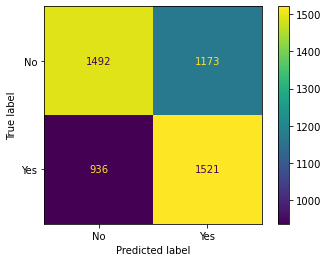

In [24]:
model_evaluation(rf_model, X_test, y_test)

              precision    recall  f1-score   support

          No       0.57      0.66      0.61      2665
         Yes       0.56      0.47      0.51      2457

    accuracy                           0.57      5122
   macro avg       0.57      0.56      0.56      5122
weighted avg       0.57      0.57      0.56      5122



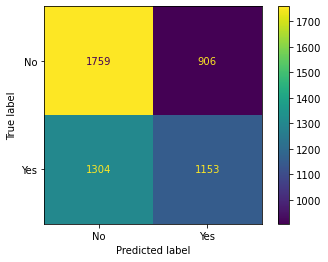

In [25]:
model_evaluation(knn_model, X_test, y_test)

As we can see, both models perform very closely on the test set compared to each other and also perform similary to the training set evaluation indicating that it is not overfit. Since it is far less computation, I will use the model without polynomial features.

Overall, the log_model seems to be performing slightly better on the test set as we get a larger sample of yes with gradual decrease in size as the probability threshold is increased.

### Log Model vs. Restriction

In the EDA notebook, we discovered by limiting the data set to the two conditions 'HighCloseAvgVol_20' >= 0.03 and 'SP_change_10'<=-0.05 had a 95% CI of (4.2%-6%) with a dataset size of 249.

Comparing to the logistic model evaluation, for a test size of 245, we need a probability restriction of 0.65.

In [26]:
log_preds = log_model.predict(X_test)
log_probs = log_model.predict_proba(X_test)[:,1]

In [27]:
data = np.column_stack((test['SP_change_Target'], y_test, log_preds, log_probs))
results = pd.DataFrame(data=data, columns=['SP_change_Target','Target', 'Prediction', 'Probability'])

In [38]:
prob_high = results[results['Probability']>=0.60]

high_prob = prob_high['SP_change_Target']

In [39]:
from scipy import stats

In [40]:
std_err = stats.sem(high_prob)
mean = np.mean(high_prob)

stats.norm.interval(0.95, loc=mean, scale=std_err)

(0.047803091738687485, 0.051697410217304514)

As we can see, the 95% CI for this model (predicting at yes at least 65%) yields a much higher 95% CI on the test set, so I will use this model. It will now be retrained on the entire set and finalized.

In [41]:
X = df.drop(['SP_change_Target', 'Target'], axis=1)
y = df['Target']

In [42]:
preprocessing = ColumnTransformer([
    ('scaler', StandardScaler(), X.select_dtypes(include='number').columns),
])

custom_scorer = make_scorer(precision_score, greater_is_better=True, pos_label='Yes')


log_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('log', LogisticRegression(max_iter=10000)),
])

log_param_grid = {'log__penalty': ['l2'],
                  'log__C': [0.005],
                  'log__solver': ['lbfgs']
                 }

custom_scorer = make_scorer(precision_score, 
                            greater_is_better=True, 
                            pos_label='Yes')

log_grid_final = GridSearchCV(estimator=log_pipeline, 
                        param_grid=log_param_grid, 
                        cv=5, 
                        scoring=custom_scorer, 
                        verbose=2)

In [43]:
log_model_final, log_params, log_best_scores = model_fit_and_scores(log_grid_final, X, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ...log__C=0.005, log__penalty=l2, log__solver=lbfgs; total time=   0.0s
[CV] END ...log__C=0.005, log__penalty=l2, log__solver=lbfgs; total time=   0.0s
[CV] END ...log__C=0.005, log__penalty=l2, log__solver=lbfgs; total time=   0.0s
[CV] END ...log__C=0.005, log__penalty=l2, log__solver=lbfgs; total time=   0.0s
[CV] END ...log__C=0.005, log__penalty=l2, log__solver=lbfgs; total time=   0.0s


              precision    recall  f1-score   support

          No       0.57      0.69      0.62     26192
         Yes       0.58      0.46      0.51     25019

    accuracy                           0.57     51211
   macro avg       0.58      0.57      0.57     51211
weighted avg       0.58      0.57      0.57     51211



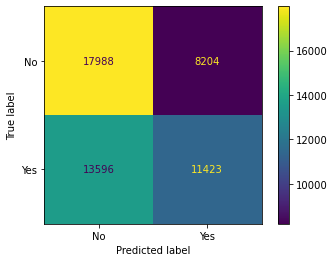

In [44]:
model_evaluation(log_grid_final, X, y)

          SP_increase  Count
0.400000     0.032228  44502
0.416667     0.033386  40733
0.433333     0.034592  36647
0.450000     0.035917  32157
0.466667     0.037346  27833
0.483333     0.038894  23475
0.500000     0.040680  19627
0.516667     0.041846  16313
0.533333     0.043468  13487
0.550000     0.044840  10996
0.566667     0.046580   8872
0.583333     0.048508   7126
0.600000     0.049750   5653
0.616667     0.051802   4463
0.633333     0.052880   3443
0.650000     0.054111   2589
0.666667     0.055619   1982
0.683333     0.058163   1454
0.700000     0.058429   1067
0.716667     0.058764    728
0.733333     0.059640    462
0.750000     0.062724    281
0.766667     0.071681    169
0.783333     0.061025     85
0.800000     0.071934     42


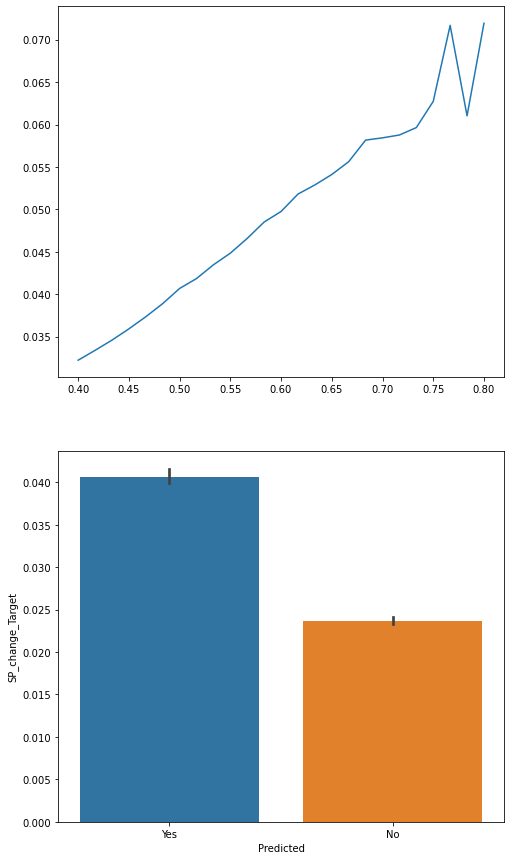

In [45]:
compare_prediction(log_grid_final, X, y, df)

In [46]:
log_preds = log_model_final.predict(X)
log_probs = log_model_final.predict_proba(X)[:,1]

data = np.column_stack((df['SP_change_Target'], df['Target'], log_preds, log_probs))
results = pd.DataFrame(data=data, columns=['SP_change_Target','Target', 'Prediction', 'Probability'])

prob_high = results[results['Probability']>=0.60]

high_prob = prob_high['SP_change_Target']

std_err = stats.sem(high_prob)
mean = np.mean(high_prob)

stats.norm.interval(0.95, loc=mean, scale=std_err)

(0.047803091738687485, 0.051697410217304514)

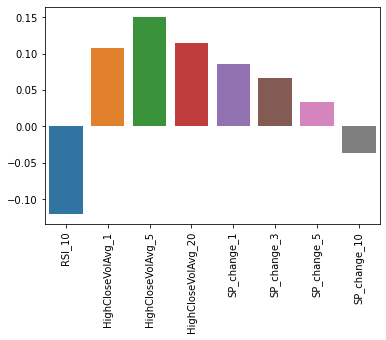

In [47]:
feats = X.columns
coefs = log_grid_final.best_estimator_[1].coef_[0]

sns.barplot(x=feats, y=coefs)
plt.xticks(rotation=90);

As we can see, this model does not outperform simply restricting our data set by two features. (95% CI for mean of (4.9, 5.4)) vs the 95% CI for the model above of (4.8, 5.2).

Due to this I will simply use the two restrictions discovered. (SP_change_10 <= -0.05 and HighCloseVolAvg_20 >= 0.03)

In [48]:
from joblib import dump

In [49]:
dump(log_model_final, 'FinalStockModel.joblib')

['FinalStockModel.joblib']

### Final Comments

Overall, the importance of only considering when the probability of a yes is at least 60% is important. It has an average mean the same as restricting the two features, but with a much larger sample size, the 95% CI is much tighter, which gives more confidence.